In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from scipy.io import wavfile as wav
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [2]:
meta_data = pd.read_csv("metadata/UrbanSound8K.csv")  

np.shape(meta_data) # (8732, 8)
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
audio_d_list = []

for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('metadata/audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    
    # extracting channels, sampling rate, bit rate and duration
    data = sf.SoundFile(file_name)
    duration = float(meta_data.iloc[index,3])-float(meta_data.iloc[index,2])
    audio_d_list.append([data.channels,
                         data.samplerate,
                         data.subtype[4:],
                         duration])

audio_property = pd.DataFrame(audio_d_list, 
                          columns=['num_channels','sample_rate','bit_depth','duration'])

In [4]:
def feature_extractor(file_name,scale=False,padding=False,max_pad=None,n=40):
    '''
    Function to extract features from the audio file
    Does the following things using Librosa library:
        - Converts the sampling rate to 22.05 KHz
        - Normalize the Bit-depth values of the audio
        - Merge the audio channels into a Mono (single) channel
    Parameters: 
    Input:
        file_name : string; 
                    Path of the file to be processed 
        scale : False; 
                True when 1D features are required calculated 
                by taking mean along the axis
        padding : False; 
                  True when 2D features are required with padding
        max_pad : None [int]; 
                  Maxium size of a padded image/array. 
                  Required when padding is set to True
        n = 40 [int]; 
            Number of MFCCs to return          
    Output:
        mfccs = array of mfccs features.
                (1D when scaling = True
                 2D when padding = True)   
    '''
    try:        
        audio, sample_rate = librosa.load(file_name, 
                                          res_type='kaiser_fast') 
        
        mfccs = librosa.feature.mfcc(y = audio, 
                                     sr = sample_rate, 
                                     n_mfcc = n) 
            
        if padding:
            pad_width = max_pad - mfccs.shape[1]
            mfccs = np.pad(mfccs, 
                           pad_width=((0, 0), (0, pad_width)), 
                           mode='constant')
            
        if scale: 
            mfccs = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [5]:

feat_list = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('metadata/audio/'),
                             'fold'+str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    
    data = feature_extractor(file_name,scale=True)
    feat_list.append([data, class_label])

features_1D = pd.DataFrame(feat_list, columns=['feature','class_label'])

print('Processed ', len(features_1D), ' files')
print('Output Feature shape ',np.shape(features_1D.iloc[0,0]))

C:\Users\min\anaconda3\envs\rtx\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\min\anaconda3\envs\rtx\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\min\anaconda3\envs\rtx\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


Processed  8732  files
Output Feature shape  (40,)


In [7]:
features_1D.to_pickle("features_1D.pkl")

In [6]:
feat_list = []
feat_list_padded = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('metadata/audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    class_id = row["classID"]
    
    data = feature_extractor(file_name)
    feat_list.append([data, class_id])
    
    data = feature_extractor(file_name,padding=True,max_pad = 174)
    feat_list_padded.append([data, class_label])
    
features_wo_pad = pd.DataFrame(feat_list, columns=['feature','class_label'])
features_2D = pd.DataFrame(feat_list_padded, columns=['feature','class_label'])

print('Processed ', len(features_2D), ' files')
print('Output Feature Padded shape ',np.shape(features_2D.iloc[0,0]))

Processed  8732  files
Output Feature Padded shape  (40, 174)


In [8]:
features_wo_pad.to_pickle("features_wo_pad.pkl")
features_2D.to_pickle("features_2D.pkl")

In [10]:
features_1D = pd.read_pickle("features_1D.pkl")
features_2D = pd.read_pickle("features_2D.pkl")
features_wo_pad = pd.read_pickle("features_wo_pad.pkl")

In [11]:
sound_class_dic = meta_data.groupby(['class', 'classID']).size()
sound_sample = []

for c in range(10):
    for index, row in features_wo_pad.iterrows():
        if c == row['class_label']:
            sound_sample.append(row)
            break

In [13]:
X_1D = np.array(features_1D.feature.tolist())
y_1D = np.array(features_1D.class_label.tolist())

# Encode the classification labels
label_encoder = LabelEncoder()
yy_1D = to_categorical(label_encoder.fit_transform(y_1D))

In [14]:
X_2D = np.array(features_2D.feature.tolist())
y_2D = np.array(features_2D.class_label.tolist())

# Encode the classification labels
yy_2D = to_categorical(label_encoder.transform(y_2D))

In [15]:
x_train_sl_1D, x_test_sl_1D, y_train_sl_1D, y_test_sl_1D = train_test_split(X_1D,y_1D,test_size=0.2,random_state =27)
# x_train_sl_2D, x_test_sl_2D, y_train_sl_2D, y_test_sl_2D = train_test_split(
#     X_2D.reshape(X_2D.shape[0],X_2D.shape[1]*X_2D.shape[2]),yy_2D,test_size=0.2,random_state = 42)
x_train_1D, x_test_1D, y_train_1D, y_test_1D = train_test_split(X_1D, yy_1D, test_size=0.2, random_state = 27)
x_train_2D, x_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, yy_2D, test_size=0.2, random_state = 27)

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [17]:
n_labels = yy_1D.shape[1]
in_shape = x_train_1D.shape[1]
n_layers = 2
n_nodes = 100

model_num = 4

# Construct model 
model = Sequential()

model.add(Dense(n_nodes, input_shape=(in_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_nodes))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [18]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_train_1D, y_train_1D, verbose=0)
accuracy = 100*score[1] 

print("Pre-training accuracy: %.4f%%" % accuracy)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4100      
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [20]:
n_epochs = 100
n_batch = 32

start = datetime.now()

history = model.fit(x_train_1D, 
                    y_train_1D,
                    batch_size=n_batch,
                    epochs=n_epochs,
                    validation_data=(x_test_1D, y_test_1D),
                    verbose=1)

duration = datetime.now() - start
print("Training finished in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 80us/step - loss: 0.9842 - accuracy: 0.6651 - val_loss: 0.8150 - val_accuracy: 0.7270
Epoch 2/100
6985/6985 [==============================] - 1s 87us/step - loss: 0.9799 - accuracy: 0.6567 - val_loss: 0.8284 - val_accuracy: 0.7230
Epoch 3/100
6985/6985 [==============================] - 1s 84us/step - loss: 0.9807 - accuracy: 0.6649 - val_loss: 0.8380 - val_accuracy: 0.7184
Epoch 4/100
6985/6985 [==============================] - 0s 72us/step - loss: 0.9641 - accuracy: 0.6663 - val_loss: 0.8208 - val_accuracy: 0.7315
Epoch 5/100
6985/6985 [==============================] - 1s 83us/step - loss: 0.9805 - accuracy: 0.6643 - val_loss: 0.8247 - val_accuracy: 0.7230
Epoch 6/100
6985/6985 [==============================] - 1s 82us/step - loss: 0.9792 - accuracy: 0.6691 - val_loss: 0.8154 - val_accuracy: 0.7218
Epoch 7/100
6985/6985 [==============================] - 1s 79us/step - loss

In [30]:
SVM = svm.SVC(C=10.0, gamma=0.001)

# train the model
SVM.fit(x_train_sl_1D,y_train_sl_1D)

y_pred = SVM.predict(x_test_sl_1D)

In [31]:
train_accu =  SVM.score(x_train_sl_1D, y_train_sl_1D)
test_accu = SVM.score(x_test_sl_1D, y_test_sl_1D)

print('Training Accuracy: %.4f%%'% (train_accu*100))
print('Test Accuracy: %.4f%%'% (test_accu*100))

Training Accuracy: 99.8282%
Test Accuracy: 89.8683%


In [32]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

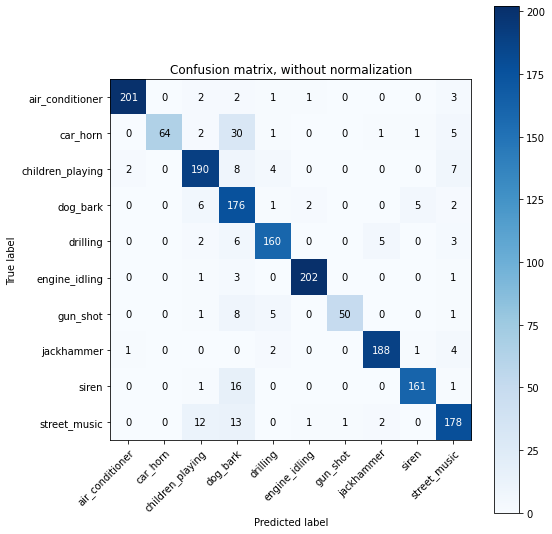

In [33]:

class_names = meta_data.groupby(['class', 'classID'], as_index = False).sum()['class']
plot_confusion_matrix(y_test_sl_1D, y_pred, classes=class_names, cmap=plt.cm.Blues)
plt.show()